In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2

In [20]:
# Directorios principales del dataset
train_dir =  './Dataset128x128_2/train'
test_dir =  './Dataset128x128_2/test'

# Crear el generador de datos con las transformaciones
datagen = ImageDataGenerator()

# Tamaño del lote
batch_size = 32

# Generador para el conjunto de entrenamiento
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb', # Convertir automáticamente de 1 canal a 3 canales iguales
    shuffle=True,
    seed=42)

test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    seed=42)

Found 13392 images belonging to 2 classes.
Found 3724 images belonging to 2 classes.


In [21]:
# Definimos una función para crear el modelo base utilizando EfficientNetB0
def create_base_model(input_shape):
    # Construcción del modelo utilizando EfficientNetB0
    effnet = EfficientNetB0(weights='imagenet', 
                            include_top=False, 
                            input_shape=input_shape)
    
    # Congelar todas las capas
    for layer in effnet.layers:
        layer.trainable = False

    # Descongelar las últimas capas
    if 8 > 0:
        for layer in effnet.layers[-8:]:
            layer.trainable = True 
    
    # Retornar el modelo base con las capas convolucionales de EfficientNet
    return Model(inputs=effnet.input, outputs=effnet.output)

# Tamaño de la imagen de entrada
input_shape = (128, 128, 3)

# Crear modelos base 
base_model = create_base_model(input_shape)

# Definir la entrada y salida del modelo
input = Input(shape=input_shape, name='input')
x = base_model(input)
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Aplana las salidas del modelo base

# Capas densas
x = Dropout(0.7, name='dropout_1')(x)
x = Dense(512, kernel_regularizer=L1L2(l1=0.0003, l2=0.0005), activation='relu', name='dense_1')(x)

x = Dropout(0.7, name='dropout_2')(x)
x = Dense(256, kernel_regularizer=L1L2(l1=0.0003, l2=0.0005), activation='relu', name='dense_2')(x)

x = Dropout(0.7, name='dropout_3')(x)
x = Dense(128, kernel_regularizer=L1L2(l1=0.0003, l2=0.0005), activation='relu', name='dense_3')(x)

# Capa de salida
output = Dense(2, activation='softmax', name='output')(x)  # 2 etiquetas de clasificación

# Definir el modelo con una sola entrada
model = Model(inputs=input, outputs=output)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    
# Resumen del modelo
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 model_2 (Functional)        (None, 4, 4, 1280)        4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               655872    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                           

In [22]:
start = time.time()
# Entrenar el modelo
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=test_generator,
                    verbose=1)
end = time.time()

# Obtener el tiempo de ejecución
elapsed_time = end - start
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

print('Tiempo finalizado de entrenamiento')
print(f'{int(hours)} horas, {int(minutes)} minutos, {int(seconds)} segundos')


Epoch 1/50
419/419 [==============================] - 18s 34ms/step - loss: 9.1719 - accuracy: 0.5420 - val_loss: 8.6811 - val_accuracy: 0.7186
Epoch 2/50
419/419 [==============================] - 13s 31ms/step - loss: 8.4230 - accuracy: 0.5994 - val_loss: 7.9706 - val_accuracy: 0.7570
Epoch 3/50
419/419 [==============================] - 15s 35ms/step - loss: 7.6770 - accuracy: 0.6513 - val_loss: 7.2099 - val_accuracy: 0.7707
Epoch 4/50
419/419 [==============================] - 15s 36ms/step - loss: 6.9007 - accuracy: 0.6921 - val_loss: 6.4465 - val_accuracy: 0.7712
Epoch 5/50
419/419 [==============================] - 15s 37ms/step - loss: 6.1162 - accuracy: 0.7148 - val_loss: 5.6596 - val_accuracy: 0.7769
Epoch 6/50
419/419 [==============================] - 16s 39ms/step - loss: 5.3252 - accuracy: 0.7298 - val_loss: 4.8726 - val_accuracy: 0.7836
Epoch 7/50
419/419 [==============================] - 17s 40ms/step - loss: 4.5488 - accuracy: 0.7437 - val_loss: 4.1276 - val_accuracy:

In [ ]:
# Guardar el modelo completo en formato h5
model.save('modelo_entrenado_2.h5')

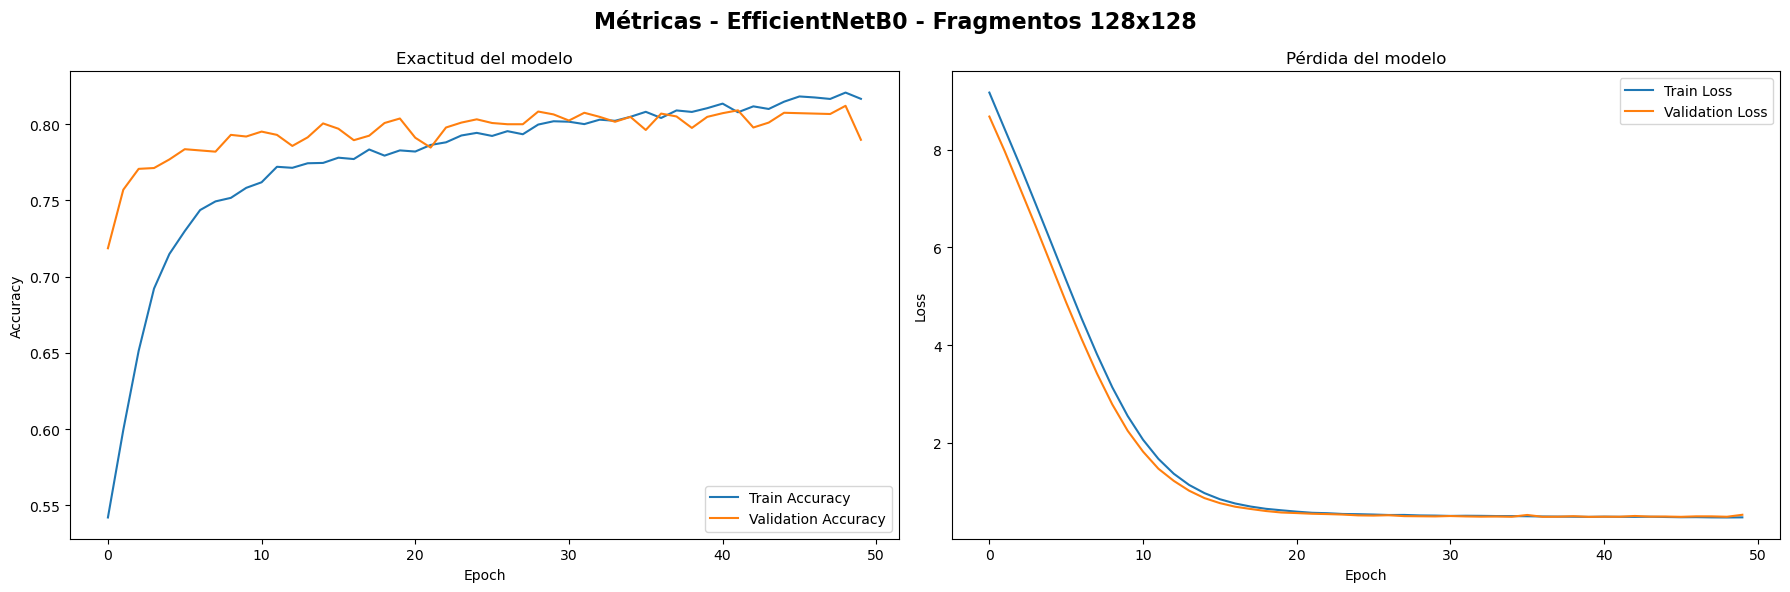

In [24]:
def plot_history(history):
    # Crear una imagen con dos subgraficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Grafico de precision
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Exactitud del modelo')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')

    # Grafico de perdida
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Pérdida del modelo')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper right')

    fig.suptitle('Métricas - EfficientNetB0 - Fragmentos 128x128', fontsize=16, fontweight='bold')

    # Guardar la imagen
    plt.tight_layout()  
    plt.show()

# Graficar el entrenamiento
plot_history(history)


Found 4172 images belonging to 2 classes.
131/131 [==============================] - 4s 29ms/step


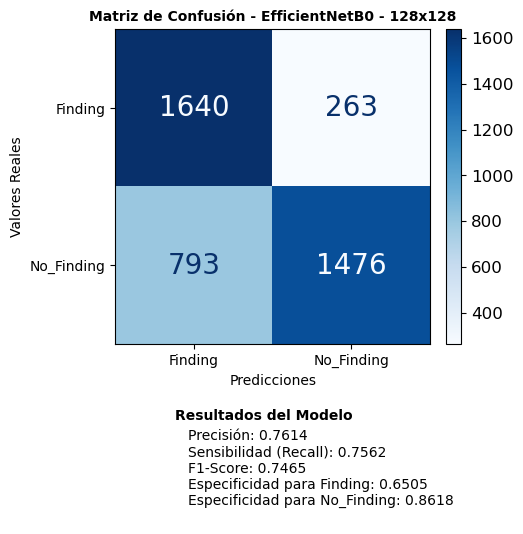

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score

# Cargar el modelo entrenado
model = load_model('modelo_entrenado_3.h5')

test_dir =  './Dataset128x128_2/prueba'

# Crear el generador de datos con las transformaciones
datagen = ImageDataGenerator()

# Tamaño del lote
batch_size = 32

prueba_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    seed=42)

# Obtener etiquetas verdaderas y etiquetas de clase
prueba_true_classes = prueba_generator.classes
class_labels = list(prueba_generator.class_indices.keys())

# Número de pasos en el conjunto de prueba
prueba_steps = len(prueba_generator)

# Hacer predicciones con el modelo en el conjunto de prueba
prueba_predictions = model.predict(prueba_generator, steps=prueba_steps)

# Convertir predicciones a clases
test_predicted_classes = np.argmax(prueba_predictions, axis=1)

# Calcular especificidad para cada clase
def calculate_specificity(confmat):
    tn = confmat.sum() - confmat.sum(axis=1) - confmat.sum(axis=0) + np.diag(confmat)
    fp = confmat.sum(axis=0) - np.diag(confmat)
    # Asegurarse de que no haya división por cero
    specificity = tn / (tn + fp)
    specificity = np.nan_to_num(specificity)  # Reemplaza NaN por 0 si hay divisiones por cero
    return specificity

# Función para agregar las métricas a la imagen
def plot_confusion_matrix_with_metrics(confmat, prueba_true_classes, prueba_predicted_classes, class_labels):
    # Calcular las métricas
    precision = precision_score(prueba_true_classes, test_predicted_classes, average='macro')
    recall = recall_score(prueba_true_classes, test_predicted_classes, average='macro')
    f1 = f1_score(prueba_true_classes, test_predicted_classes, average='macro')
    specificity = calculate_specificity(confmat)

    # Crear la figura y el eje para la matriz de confusión
    fig, ax = plt.subplots(figsize=(5, 5))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=class_labels)
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d', colorbar=False)  # Desactiva la barra de color si no es necesaria

    # Ajustar los números dentro de la matriz
    for text in disp.text_.ravel():
        text.set_fontsize(20)  # Cambia el tamaño de los números

    plt.title('Matriz de Confusión - EfficientNetB0 - 128x128', fontsize=10, fontweight='bold')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Reales')

    # Añadir una barra de color proporcional a los valores
    cbar = fig.colorbar(disp.im_, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=12)  # Ajusta el tamaño de las etiquetas de la barra de color

    # Ajustar la figura para hacer espacio para las métricas en la parte inferior
    plt.subplots_adjust(bottom=0.25)

    # Añadir un texto con las métricas en la parte inferior de la imagen
    title_text = 'Resultados del Modelo'
    metrics_text = (f'Precisión: {precision:.4f}\n'
                    f'Sensibilidad (Recall): {recall:.4f}\n'
                    f'F1-Score: {f1:.4f}\n')
    
    # Especificidad por clase
    for i, class_label in enumerate(class_labels):
        metrics_text += f'Especificidad para {class_label}: {specificity[i]:.4f}\n'

    # Combinar el título y las métricas en un solo recuadro
    plt.figtext(0.5, 0.12, title_text, ha="center", va="top", fontsize=10, weight='bold', bbox={"facecolor": "lightgray", "alpha": 0})

    # Añadir las métricas, alineadas a la izquierda, justo debajo del título
    plt.figtext(0.35, 0.08, metrics_text, ha="left", va="top", fontsize=10, bbox={"facecolor": "lightgray", "alpha": 0})

    plt.show()

# Calcular matriz de confusión
confmat = confusion_matrix(y_true=prueba_true_classes, y_pred=test_predicted_classes)

# Generar la imagen de la matriz de confusión con las métricas
plot_confusion_matrix_with_metrics(confmat, prueba_true_classes, test_predicted_classes, class_labels)